In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm

In [90]:
data_prefix = "ling_data/"
#data_prefix = "data/"
course = pd.read_csv(data_prefix + "course.csv")
course_element = pd.read_csv(data_prefix + "course_element.csv") 
course_module = pd.read_csv(data_prefix + "course_module.csv") 
sol_log = pd.read_csv(data_prefix + "solution_log.csv") 
u_course_progress = pd.read_csv(data_prefix + "user_course_progress.csv") 
u_element_progress = pd.read_csv(data_prefix + "user_element_progress.csv") 
u_module_progress = pd.read_csv(data_prefix + "user_module_progress.csv")
#users = pd.read_csv("user_course_ids.csv")

sol_log.submission_time = pd.to_datetime(sol_log.submission_time)
u_element_progress.time_updated = pd.to_datetime(u_element_progress.time_updated)
u_module_progress.time_unlocked = pd.to_datetime(u_module_progress.time_unlocked)
u_element_progress.time_achieved = pd.to_datetime(u_element_progress.time_achieved)

#u_course_progress = u_course_progress.merge(users, on=['user_id', 'course_id'])

In [6]:
## sub_time = u_element_progress.merge(sol_log, left_on='id', right_on='element_progress_id')[['user_id', 'submission_time', 'course_id']]
def calc_active_days_for_users(date, window_size, course, course_module, course_element, u_course_progress, u_module_progress, 
                              u_element_progress, sol_log, sub_time):
    sub_time = sub_time[(sub_time.submission_time < date) & (sub_time.submission_time > date - timedelta(days=window_size))]
    sub_time.submission_time = sub_time.submission_time.dt.round("D")
    d = dict(sub_time.groupby(["user_id"]).submission_time.nunique())

    result = pd.DataFrame()
    result["user_id"] = u_course_progress.user_id.unique()
    result["factor_value"] = result.user_id.map(d).fillna(0) / window_size


    
    return result


    
def calc_progress_current_for_users(date, window_size, course, course_module, course_element, u_course_progress, u_module_progress, 
                              u_element_progress, sol_log):
    u_element_progress.progress_current = u_element_progress.progress_current.astype(bool)
    d = u_element_progress[(u_element_progress.achieve_reason == "solved") & (u_element_progress.course_element_type == "task") &
                   (u_element_progress.time_updated < date) & (u_element_progress.time_updated > date - timedelta(days=window_size))].groupby(["user_id", "course_id"]).progress_current.sum()
    
    
    result = pd.DataFrame()
    result["user_id"] = u_course_progress.user_id
    result["course_id"] = u_course_progress.course_id
    result["progress_current"] = result.merge(d, on=["user_id", "course_id"], how="left").progress_current.fillna(0)
    return result







def calc_task_completeness_points_for_users(date, window_size, course, course_module, course_element, u_course_progress, u_module_progress, 
                              u_element_progress, sol_log):
    module2totalpoints = course_element[course_element.element_type == "task"].groupby("module_id").score.sum()
    
    module2tasks = dict(course_element[course_element.element_type == "task"].groupby("module_id").id.count())
    u_module_progress["task_count"] = u_module_progress.course_module_id.map(module2tasks)

    uidcid2possible_tasks = u_module_progress[u_module_progress.time_unlocked < date].groupby(["user_id", "course_id"]).task_count.sum()
    uidcid2solved_before = u_element_progress[(u_element_progress.time_achieved <= date - timedelta(days=window_size)) & (u_element_progress.course_element_type == "task")].groupby(["user_id", "course_id"]).progress_current.sum()
    period_progress = calc_progress_current_for_users(date, window_size, course, course_module, course_element, u_course_progress, u_module_progress, 
                                  u_element_progress, sol_log)


    uidcid2solved_before.name = "solved_before"
    uidcid2possible_tasks.name = "possible_tasks"
    
    period_progress = period_progress.merge(uidcid2solved_before, on=["user_id", "course_id"], how="left").fillna(0).merge(uidcid2possible_tasks, on=["user_id", "course_id"], how="left").dropna()
    result = pd.DataFrame()
    result["user_id"] = period_progress.user_id
    result["course_id"] = period_progress.course_id
    result["task_completeness"] = period_progress.progress_current / (period_progress.possible_tasks - period_progress.solved_before)
    return result






## Категориальная характеристика основанная на порядке решения
def calc_order_for_user(date, window_size, course, course_module, course_element, u_course_progress, u_module_progress, 
                              u_element_progress, sol_log):
    data1 = u_element_progress.loc[((u_element_progress['course_element_type'] == 'video') | (u_element_progress['course_element_type'] == 'text')) &
                              ((u_element_progress.time_updated < date) & (u_element_progress.time_updated > date - timedelta(days=window_size)))]
    data1 = data1.merge(course_element, how  = 'inner', left_on = 'course_element_id', right_on= 'element_id' )
    data1 = data1.sort_values(['user_id', 'course_id', 'course_module_id', 'time_achieved'])

    kl = pd.DataFrame(columns = ['element_progress_id', 'submission_time'], )

    kl['element_progress_id'] = sol_log['element_progress_id']
    kl['submission_time'] = sol_log['submission_time']
    kl = kl.groupby(['element_progress_id']).min('submission_time').reset_index()


    data2 = u_element_progress.merge(kl, how = 'left', left_on = 'id', right_on = 'element_progress_id')
    data2 = data2.loc[(data2['course_element_type'] == 'task')]
    data2 = data2.merge(course_element, how  = 'inner', left_on = 'course_element_id', right_on= 'element_id' )
    #data2 = data2.merge(user_course_ids, on=['user_id', 'course_id'])

    data2 = data2.sort_values(['user_id', 'course_id', 'course_module_id', 'submission_time']).reset_index()
    tasks = data2[['user_id', 'course_id', 'course_module_id', 'course_element_id', 'course_element_type']]
    tasks['time_try'] = data2['submission_time'] 
    tasks['position'] = data2['position']
    theory = data1[['user_id', 'course_id', 'course_module_id', 'course_element_id', 'course_element_type']]
    theory['time_try'] = data1['time_achieved'] 
    theory['position'] = data1['position']
    frames = [tasks, theory]
    
    
    distribution = pd.concat(frames)
    distribution = distribution.sort_values(['user_id', 'course_id', 'course_module_id', 'time_try']).reset_index()
    distribution = distribution.drop(['index'], axis = 1).drop_duplicates().reset_index()
    distribution1 = distribution.sort_values(['user_id', 'course_id', 'course_module_id', 'position']).reset_index()

    distribution1['order'] = (distribution1['position'] == distribution['position'])
    distribution1['order'] = ~distribution1['order']
    new_obj = pd.DataFrame(distribution1.groupby(['user_id', 'course_id']).order.sum())
    new_obj[new_obj["order"] > 0] = 1
    new_obj.rename(columns={"order" : "factor_value"})
    return new_obj





In [7]:
sub_time = u_element_progress.merge(sol_log, left_on='id', right_on='element_progress_id')[['user_id', 'submission_time', 'course_id']]

In [12]:
## Поинты за период / размер периода
def calc_period_mean_speed_for_users(date, window_size, course, course_module, course_element, u_course_progress, u_module_progress, 
                              u_element_progress, sol_log, sub_time):
    progress = calc_progress_current_points_for_users(date, window_size, course, course_module, course_element, u_course_progress, u_module_progress, 
                              u_element_progress, sol_log)
    result = pd.DataFrame()
    result["user_id"] = progress.user_id
    result = result.merge(progress, on="user_id", how="left").fillna(0)
    print(result.columns)
    result["factor_value"] = result.progress_current / window_size
    result.drop(columns=["progress_current"], inplace=True)
    return result

## Поинты за период / активные дни 
def calc_active_days_mean_speed_for_users(date, window_size, course, course_module, course_element, u_course_progress, u_module_progress, 
                              u_element_progress, sol_log, sub_time):
    active_days = calc_active_days_for_users(date, window_size, course, course_module, course_element, u_course_progress, u_module_progress, 
                              u_element_progress, sol_log, sub_time)
    progress = calc_progress_current_points_for_users(date, window_size, course, course_module, course_element, u_course_progress, u_module_progress, 
                              u_element_progress, sol_log)
    result = pd.DataFrame()
    result["user_id"] = progress.user_id
    result = result.merge(progress, on="user_id", how="left").merge(active_days, on="user_id", how="left").fillna(0)
    result["factor_value"] = result.progress_current / result.factor_value
    result.factor_value = result.factor_value.fillna(0)
    result.drop(columns=["progress_current"], inplace=True)
    return result


## user progress in (date - window_size days, date)
def calc_progress_current_points_for_users(date, window_size, course, course_module, course_element, u_course_progress, u_module_progress, 
                              u_element_progress, sol_log):
    d = u_element_progress[(u_element_progress.achieve_reason == "solved") & (u_element_progress.course_element_type == "task") &
                   (u_element_progress.time_updated < date) & (u_element_progress.time_updated > date - timedelta(days=window_size))].groupby(["user_id", "course_id"]).progress_current.sum()
    result = pd.DataFrame()
    result["user_id"] = u_course_progress.user_id
    result["course_id"] = u_course_progress.course_id
    result["progress_current"] = result.merge(d, on=["user_id", "course_id"], how="left").progress_current.fillna(0)
    result.progress_current = result.user_id.map(dict(result.groupby("user_id").progress_current.mean()))
    result.drop(columns=["course_id"], inplace=True)
    return result


## Доля полученных баллов из возможных за период
def calc_current_score_for_users(date, window_size, course, course_module, course_element, u_course_progress, u_module_progress, 
                              u_element_progress, sol_log):
    module2totalpoints = course_element[course_element.element_type == "task"].groupby("module_id").score.count()
    module2tasks = dict(course_element[course_element.element_type == "task"].groupby("module_id").id.count())
    u_module_progress["task_count"] = u_module_progress.course_module_id.map(module2tasks).fillna(0)

    
    uidcid2possible_tasks = u_module_progress[u_module_progress.time_unlocked < date].groupby(["user_id"]).task_count.sum()
    uidcid2solved_before = u_element_progress[(u_element_progress.time_achieved <= date - timedelta(days=window_size)) &
                                              (u_element_progress.course_element_type == "task")].groupby(["user_id"]).progress_current.sum()
    period_progress = calc_progress_current_points_for_users(date, window_size, course, course_module, course_element, u_course_progress, u_module_progress, 
                                  u_element_progress, sol_log)


    uidcid2solved_before.name = "solved_before"
    uidcid2possible_tasks.name = "possible_tasks"
    
    period_progress = period_progress.merge(uidcid2solved_before, on=["user_id"], how="left").fillna(0).merge(uidcid2possible_tasks, on=["user_id"], how="left").dropna()
    result = pd.DataFrame()
    result["user_id"] = period_progress.user_id
    result["factor_value"] = period_progress.progress_current / (period_progress.possible_tasks - period_progress.solved_before)
    
    return result


def calc_progress_current_for_users(date, window_size, course, course_module, course_element, u_course_progress, u_module_progress, 
                              u_element_progress, sol_log):
    u_element_progress.progress_current = u_element_progress.progress_current.astype(bool)
    d = u_element_progress[(u_element_progress.achieve_reason == "solved") & (u_element_progress.course_element_type == "task") &
                   (u_element_progress.time_updated < date) & (u_element_progress.time_updated > date - timedelta(days=window_size))].groupby(["user_id", "course_id"]).progress_current.sum()
    
    
    result = pd.DataFrame()
    result["user_id"] = u_course_progress.user_id
    result["course_id"] = u_course_progress.course_id
    result["progress_current"] = result.merge(d, on=["user_id", "course_id"], how="left").progress_current.fillna(0)
    return result




def calc_progress_current_for_users_text(date, window_size, course, course_module, course_element, u_course_progress, u_module_progress, 
                              u_element_progress, sol_log):
    d = u_element_progress[(u_element_progress.achieve_reason == "solved") & (u_element_progress.course_element_type.isin(["text", "video"])) &
                   (u_element_progress.time_updated < date) & (u_element_progress.time_updated > date - timedelta(days=window_size))].groupby(["user_id", "course_id"]).progress_current.count()
    
    
    result = pd.DataFrame()
    result["user_id"] = u_course_progress.user_id
    result["course_id"] = u_course_progress.course_id
    result["progress_current"] = result.merge(d, on=["user_id", "course_id"], how="left").progress_current.fillna(0)
    return result


## "доля" выполненных заданий
def calc_task_completeness_for_users(date, window_size, course, course_module, course_element, u_course_progress, u_module_progress, 
                              u_element_progress, sol_log):
    module2totalpoints = course_element[course_element.element_type == "task"].groupby("module_id").score.count()
    
    module2tasks = dict(course_element[course_element.element_type == "task"].groupby("module_id").id.count())
    u_module_progress["task_count"] = u_module_progress.course_module_id.map(module2tasks).fillna(0)

    uidcid2possible_tasks = u_module_progress[u_module_progress.time_unlocked < date].groupby(["user_id"]).task_count.sum()
    uidcid2solved_before = u_element_progress[(u_element_progress.time_achieved <= date - timedelta(days=window_size)) &
                                              (u_element_progress.course_element_type == "task")].groupby(["user_id"]).progress_current.sum()
    period_progress = calc_progress_current_for_users(date, window_size, course, course_module, course_element, u_course_progress, u_module_progress, 
                                  u_element_progress, sol_log)


    uidcid2solved_before.name = "solved_before"
    uidcid2possible_tasks.name = "possible_tasks"
    
    period_progress = period_progress.merge(uidcid2solved_before, on=["user_id"], how="left").fillna(0).merge(uidcid2possible_tasks, on=["user_id"], how="left").dropna()
    result = pd.DataFrame()
    result["user_id"] = period_progress.user_id
    result["course_id"] = period_progress.course_id
    result["task_completeness"] = period_progress.progress_current / (period_progress.possible_tasks - period_progress.solved_before)
    d = dict(result.groupby(["user_id"]).task_completeness.mean())
    result.drop(columns=["course_id", "task_completeness"], inplace=True)
    result["factor_value"] = result.user_id.map(d).fillna(0)
    
    return result


## "доля" выполненных текстов и видео
def calc_text_completeness_for_users(date, window_size, course, course_module, course_element, u_course_progress, u_module_progress, 
                              u_element_progress, sol_log):
    module2totalpoints = course_element[course_element.element_type.isin(["text", "video"])].groupby("module_id").score.count()
    
    module2tasks = dict(course_element[course_element.element_type.isin(["text", "video"])].groupby("module_id").id.count())
    u_module_progress["task_count"] = u_module_progress.course_module_id.map(module2tasks).fillna(0)

    uidcid2possible_tasks = u_module_progress[u_module_progress.time_unlocked < date].groupby(["user_id"]).task_count.sum()
    uidcid2solved_before = u_element_progress[(u_element_progress.time_achieved <= date - timedelta(days=window_size)) &
                                              (u_element_progress.course_element_type.isin(["text", "video"]))].groupby(["user_id"]).progress_current.sum()
    period_progress = calc_progress_current_for_users_text(date, window_size, course, course_module, course_element, u_course_progress, u_module_progress, 
                                  u_element_progress, sol_log)


    uidcid2solved_before.name = "solved_before"
    uidcid2possible_tasks.name = "possible_tasks"
    
    period_progress = period_progress.merge(uidcid2solved_before, on=["user_id"], how="left").fillna(0).merge(uidcid2possible_tasks, on=["user_id"], how="left").dropna()
    result = pd.DataFrame()
    result["user_id"] = period_progress.user_id
    result["course_id"] = period_progress.course_id
    result["task_completeness"] = period_progress.progress_current / (period_progress.possible_tasks - period_progress.solved_before)
    d = dict(result.groupby(["user_id"]).task_completeness.mean())
    result.drop(columns=["course_id", "task_completeness"], inplace=True)
    result["factor_value"] = result.user_id.map(d).fillna(0)
    
    return result





In [73]:
## подсчет попыток (в абсолютных значениях)
def calc_tries_for_users(date, window_size, course, course_module, course_element, u_course_progress, u_module_progress, 
                              u_element_progress, sol_log):
    result = pd.DataFrame()
    result["user_id"] = u_course_progress.user_id.unique()
    result["factor_value"] = result.user_id.map(dict(u_element_progress[(u_element_progress.time_updated < date) & (u_element_progress.time_updated > date - timedelta(days=window_size))].groupby("user_id").tries_count.sum())).fillna(0)
    return result


## Закодированное число попыток
def calc_tries_encoded_for_users(date, window_size, course, course_module, course_element, u_course_progress, u_module_progress, 
                              u_element_progress, sol_log):
    df = calc_tries_for_users(date, window_size, course, course_module, course_element, u_course_progress, u_module_progress, 
                              u_element_progress, sol_log)
    ## Деление на 4 кластера и метки были полученны на курсах по геометрии: 
    ## est = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')
    ## est.fit(df.factor_value.values.reshape(-1, 1))
    ## Xt = est.transform(df.factor_value.values.reshape(-1, 1))
    ## df["y"] = df.user_id.map(dict(u_course_progress.groupby("user_id").progress_current_ratio.mean()))
    ## df.groupby("encoded_value").y.mean()
    
    df.loc[df.factor_value < 115, "encoded_value"] = 0.293735
    df.loc[df.factor_value >= 115, "encoded_value"] = 0.744864
    df.loc[df.factor_value >= 476, "encoded_value"] = 0.855772
    df.loc[df.factor_value >= 1134, "encoded_value"] = 0.947761
    
    result = pd.DataFrame()
    result["user_id"] = df.user_id
    result["factor_value"] = df.encoded_value
    return result

In [76]:
calc_tries_encoded_for_users(date, window_size, course, course_module, course_element, u_course_progress, u_module_progress, 
                              u_element_progress, sol_log).factor_value

0        0.293735
1        0.293735
2        0.293735
3        0.293735
4        0.293735
           ...   
14381    0.293735
14382    0.293735
14383    0.293735
14384    0.293735
14385    0.293735
Name: factor_value, Length: 14386, dtype: float64

In [125]:
sol_log

,id,tries_count,hints_used,score,submission_time,element_progress_id,verdict
0,2883556,17,0,0.0,2019-11-09 17:10:35.005666,13663128,wrong
1,2955430,19,0,0.0,2019-11-15 15:52:11.121136,13663128,wrong
2,2955434,20,0,0.0,2019-11-15 15:52:26.919004,13663128,wrong
3,3398631,32,0,0.0,2019-12-14 19:28:49.940688,13663128,wrong
4,3471679,46,0,0.0,2019-12-20 13:48:58.288691,13663128,wrong
...,...,...,...,...,...,...,...
2267984,20852951,1,0,4.0,2020-11-30 21:29:50.216797,69801613,ok
2267985,19749902,1,0,4.0,2020-06-04 18:49:42.359620,69011553,ok
2267986,18706612,1,0,4.0,2020-05-27 20:30:25.434104,63751068,ok
2267987,19458064,1,0,4.0,2020-05-08 08:20:23.357654,67663315,ok


,id,tries_count,hints_used,score,submission_time,element_progress_id,verdict
107516,15775931,2,0,0.0,2020-07-18 16:46:45.203800,55136290,wrong
107517,15775934,3,0,0.0,2020-07-18 16:46:48.994779,55136290,wrong
107518,15775938,4,0,0.0,2020-07-18 16:46:53.140069,55136290,wrong
107519,15776158,6,0,1.0,2020-07-18 16:55:26.848034,55136290,ok
107520,15775913,1,0,0.0,2020-07-18 16:46:21.816657,55136290,wrong
...,...,...,...,...,...,...,...
2267840,19222197,1,0,4.0,2020-07-17 17:48:44.500027,66446867,ok
2267852,18749008,1,0,4.0,2020-07-19 19:08:49.445333,64143622,ok
2267896,19857518,1,0,4.0,2020-07-19 21:51:20.688873,69418519,ok
2267927,19806593,1,0,4.0,2020-07-28 08:38:11.184070,69261707,ok


In [144]:
def relax(df):
    df['min_sub_time_next'] = df['min_sub_time'].shift(periods=-1)
    df['relax_time'] = df['min_sub_time_next'] - df['max_sub_time']
    new_df = df
    return new_df

## факторы активности пользователя
def calc_activity_for_users(date, window_size, course, course_module, course_element, u_course_progress, u_module_progress, 
                              u_element_progress, sol_log):
    u_tasks_done = u_module_progress.groupby(['user_id'])['tasks_done'].sum().reset_index()


    u_course_regularity = u_element_progress.merge(sol_log[(sol_log.submission_time < date) & (sol_log.submission_time > date - timedelta(days=window_size))], how='left', left_on='id', right_on='element_progress_id')[['user_id', 'submission_time', 'course_id', 'verdict']]

    u_course_regularity['submission_time'] = pd.to_datetime(u_course_regularity['submission_time'])

    u_course_regularity.sort_values('submission_time', inplace=True)

    u_course_regularity['delta'] = u_course_regularity.groupby(['user_id'])['submission_time'].diff()

    u_course_regularity['delta'] = u_course_regularity['delta'].apply(lambda x: round(x.total_seconds(), 2))

    u_max_delta_sub_time = u_course_regularity.groupby(['user_id'])['delta'].max().reset_index()

    #to_csv
    ## u_max_delta_sub_time.to_csv('user_max_delta_sub_time.csv', index=False)

    u_course_regularity['is_new_period'] = u_course_regularity['delta'] > (3600 * 24)

    u_course_regularity['period_of_activity'] = u_course_regularity.groupby(['user_id'])['is_new_period'].apply(lambda x: x.cumsum())

    # verdict == 'ok'
    grouped = u_course_regularity[u_course_regularity['verdict'] == 'ok'].groupby(['user_id', 'period_of_activity'])

    u_course_period_activity = grouped['verdict'].apply(lambda x: x.count()).reset_index()

    max_done = u_course_period_activity.groupby(['user_id'])['verdict'].max().reset_index()
    mean_done = u_course_period_activity.groupby(['user_id'])['verdict'].mean().reset_index()
    med_done = u_course_period_activity.groupby(['user_id'])['verdict'].median().reset_index()
    
    u_course_activity = pd.DataFrame()
    u_course_activity["user_id"] = u_course_progress.user_id.unique()
    u_course_activity = u_course_activity.merge(max_done, on=['user_id'])
    u_course_activity = u_course_activity.merge(mean_done, on=['user_id'])
    u_course_activity = u_course_activity.merge(med_done, on=['user_id'])

    #all tries
    grouped = u_course_regularity.groupby(['user_id', 'period_of_activity'])
    u_course_period_activity = grouped['verdict'].apply(lambda x: x.count()).reset_index()

    #max tries in period of activity
    max_done = u_course_period_activity.groupby(['user_id'])['verdict'].max().reset_index()
    mean_done = u_course_period_activity.groupby(['user_id'])['verdict'].mean().reset_index()
    med_done = u_course_period_activity.groupby(['user_id'])['verdict'].median().reset_index()

    u_course_activity = u_course_activity.merge(max_done, on=['user_id'])
    u_course_activity = u_course_activity.merge(mean_done, on=['user_id'])
    u_course_activity = u_course_activity.merge(med_done, on=['user_id'])

    u_course_activity.set_axis(['user_id', 'max_done', 'mean_done', 'med_done', 'max_tries', 'mean_tries', 'med_tries'], axis='columns', inplace=True)

    u_course_regularity[u_course_regularity['is_new_period'] == True]

    u_course_period_info_1 = u_course_regularity.groupby(['user_id', 'period_of_activity'])['submission_time'].min().reset_index(name='min_sub_time')
    u_course_period_info_2 = u_course_regularity.groupby(['user_id', 'period_of_activity'])['submission_time'].max().reset_index(name='max_sub_time')
    u_course_period_info = u_course_period_info_1.merge(u_course_period_info_2, on=['user_id', 'period_of_activity'])



    relax_table = relax(u_course_period_info)
    relax_table['relax_time'] = relax_table['relax_time'].apply(lambda x: round(x.total_seconds(), 2))
    relax_table = relax_table.loc[relax_table['relax_time'] > 0]
    relax_table_1 = relax_table.groupby(['user_id']).relax_time.mean('relax_time').reset_index(name = 'mean_relax_time')
    relax_table_2 = relax_table.groupby(['user_id']).relax_time.median('relax_time').reset_index(name = 'median_relax_time')

    #in parts of days - (by defautl they are available in seconds)
    relax_table_1['mean_relax_time'] = relax_table_1['mean_relax_time']/(3600*24)
    relax_table_2['median_relax_time'] = relax_table_2['median_relax_time']/(3600*24)

    u_course_activity = u_course_activity.merge(relax_table_1, on=['user_id'])
    u_course_activity = u_course_activity.merge(relax_table_2, on=['user_id'])
    u_course_activity = u_course_activity.merge(u_max_delta_sub_time, on=["user_id"])
    return u_course_activity

In [145]:
df = calc_activity_for_users(date, 1000, course, course_module, course_element, u_course_progress, u_module_progress, 
                              u_element_progress, sol_log)

In [148]:
df

,user_id,max_done,mean_done,med_done,max_tries,mean_tries,med_tries,mean_relax_time,median_relax_time,delta
0,100120050111539982,86,43.500000,43.5,293,199.000000,199.0,127.273346,127.273346,11723822.59
1,100120030110035096,163,48.214286,53.0,378,83.428571,73.0,21.487613,1.983282,18814456.81
2,100119950110754301,12,12.000000,12.0,20,20.000000,20.0,190.339649,190.339649,436.78
3,100119750110076224,1,1.000000,1.0,4,4.000000,4.0,4.801540,4.801540,9.95
4,100119890110155820,895,113.000000,9.0,975,113.000000,12.0,22.736328,2.196099,16274829.63
...,...,...,...,...,...,...,...,...,...,...
6134,100120080111094015,18,10.666667,8.0,18,10.666667,8.0,6.571089,6.571089,854368.58
6135,100120050110216063,16,13.500000,13.5,16,13.500000,13.5,5.835220,5.835220,504163.01
6136,100120030110047177,24,8.166667,4.5,24,8.166667,4.5,2.943594,1.747272,659871.12
6137,100120040111161094,16,7.333333,6.0,16,7.333333,6.0,3.194601,1.776463,756789.41


In [295]:
ans1 = calc_active_days_for_users(date, window_size, course, course_module, course_element, u_course_progress, u_module_progress, 
                              u_element_progress, sol_log, sub_time)

C:\Users\Sirius\anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Фичи: 
course_done - получен ли сертификат 1 уровня
progress_current_ratio - доля полученных баллов за курс
progress_current - сколько всего баллов полученно 
total_courses_done - сколько всего закрыл курсов ученик
total_tries_overall - сколько попыток сдачи сделал на всех курсах 
tries_count - сколько попыток сделал ученик на данном курсе
task_problems_in_course	text_problems_in_course	video_problems_in_course - сколько в курсе соответсвующих задач
mean_progress - на сколько баллов люди в среднем прорешивают курс
total_participants - сколько всего участников было на курсе
advanced_modules_count - сколько в курсе продвинутых модулей (в геометрии 0)
transferred_count - сколько задач пользователем перенесено
tries_efficiency - кол-во баллов в курсе делить на кол-во попыток в курсе
active_days - кол-во активных дней работы

То что еще надо юзать: 
knowledge_area_id

In [84]:
u_course_progress.columns

Index(['id', 'user_id', 'course_id', 'modules_achieved',
       'advanced_modules_done', 'time_created', 'time_updated',
       'modules_closed', 'modules_done', 'course_done', 'progress_current',
       'progress_current_ratio', 'total_courses_done', 'total_tries_overall',
       'tries_count', 'task_problems_in_course', 'text_problems_in_course',
       'video_problems_in_course', 'mean_progress', 'total_participants',
       'advanced_modules_count', 'transferred_count', 'tries_efficiency',
       'active_days', 'solving_speed'],
      dtype='object')

In [92]:
df = pd.DataFrame()

df["user_id"] = u_course_progress[u_course_progress.course_id.isin([88])].user_id
df["course_id"] = u_course_progress[u_course_progress.course_id.isin([88])].course_id
df["progress_ratio"] = u_course_progress[u_course_progress.course_id.isin([88])].progress_current_ratio



In [93]:
df.to_csv("88.csv", index=False)

In [98]:
df1 = pd.read_csv("25-237.csv")
df2 = pd.read_csv("88.csv")

In [101]:
pd.concat([df1, df2]).to_csv("progress.csv")

In [91]:
## Посчитаем, сколько в курсе можно заработать максимум баллов
course_to_max_points = dict(course_module.groupby("course_id").progress_max.sum())


## Подсчитаем, закрыл ли пользователь курс на сертификат первого уровня

d = dict(course_module[~course_module.is_advanced & course_module.level == 1].groupby(by="course_id").id.unique().apply(len))
u_course_progress["course_done"] = u_course_progress.course_id.map(d) <= u_course_progress.modules_achieved


## Подсчитаем по пользователю, сколько баллов он заработал

u_course_progress = u_course_progress.merge(u_element_progress.groupby(['user_id', 'course_id']).\
                                            progress_current.sum(), on=['user_id', 'course_id'])

## Найдем долю баллов которую получил пользователь от максимального числа баллов

u_course_progress["progress_current_ratio"] = u_course_progress.progress_current / u_course_progress.course_id.map(course_to_max_points)


## Найдем, сколько всего ученик закрыл курсов

u_course_progress["total_courses_done"] = u_course_progress.user_id.map(dict(u_course_progress.groupby("user_id").course_done.sum()))





## Найдем, сколько всего попыток сдачи задач, сделал ученик. total_tries_overall - считая все курсы, 
## total_tries - учитывая только данный курс

u_course_progress["total_tries_overall"] = u_course_progress.user_id.map(dict(u_element_progress.groupby("user_id").tries_count.sum()))
u_course_progress = u_course_progress.merge( u_element_progress.groupby(["user_id", "course_id"]) \
                        .tries_count.sum(), on=['user_id', 'course_id'], how = "left")





## Найдем, сколько в курсе видео / текстовых / задачный элементов

course_element["course_id"] = course_element.module_id.map(dict(zip(course_module.id, course_module.course_id)))

for name in ["task", "text", "video"]:
    u_course_progress[name + "_problems_in_course"] = u_course_progress.course_id. \
    map(dict(course_element[course_element.element_type == name].groupby("course_id").id.count()))
    
elem_count = u_course_progress["task_problems_in_course"] + u_course_progress["video_problems_in_course"] + u_course_progress["text_problems_in_course"]

for name in ["task", "text", "video"]:
    u_course_progress[name + "_problems_in_course"] /= elem_count
     


## Найдем, сколько баллов получают люди за курс в среднем

u_course_progress["mean_progress"] = u_course_progress.course_id.map(dict(u_course_progress.groupby("course_id").progress_current_ratio.sum() / u_course_progress.groupby("course_id").progress_current_ratio.count()))


## Найдем, сколько всего участников на курсе


u_course_progress["total_participants"] = u_course_progress.course_id.map(dict(u_course_progress.groupby("course_id").id.count()))



## Найдем, сколько продвинутых модулей на курсе
u_course_progress["advanced_modules_count"] = u_course_progress.course_id.map(course_module.groupby("course_id").is_advanced.sum())



## Посчитаем, сколько задач каждый пользователь перенес 

d = u_element_progress[u_element_progress.achieve_reason == "transferred"].groupby(["user_id", "course_id"]).id.count()
u_course_progress["transferred_count"] = u_course_progress.merge(d, on=['user_id', 'course_id'], how="left").id_y.fillna(0)


## Посчитаем кол-во баллов полученное за курс учеников разделенное на количество попыток в курсе
u_course_progress["tries_efficiency"] = u_course_progress.progress_current / u_course_progress.tries_count


## Посчитаем  дни активности

sub_time = u_element_progress.merge(sol_log, left_on='id', right_on='element_progress_id')[['user_id', 'submission_time', 'course_id']]

sub_time.submission_time = pd.to_datetime(sub_time.submission_time)
sub_time.submission_time = sub_time.submission_time.dt.round("D")

d = sub_time.groupby(["user_id", "course_id"]).submission_time.nunique()

u_course_progress["active_days"] = u_course_progress.merge(d, on=['user_id', 'course_id'], how="left").submission_time.fillna(0)


## Найдем баллы деленные на кол-во дней активности (скорость набора баллов)
u_course_progress["solving_speed"] = u_course_progress.progress_current / u_course_progress.active_days


## я не знаю что это и где оно появляется


u_course_progress.to_csv("to_combine/user_course_progress_done.csv", index=None)


KeyError: "['Unnamed: 0'] not found in axis"

In [8]:
from datetime import timedelta
import datetime

In [9]:
window_size = 14

In [10]:
date = pd.to_datetime('2020-07-30') 

In [102]:
df = pd.read_csv("learning_data.csv")

<AxesSubplot:>

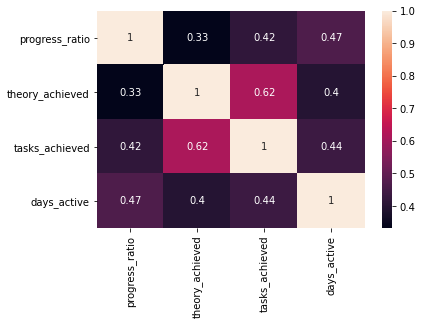

In [110]:
sns.heatmap(df.corr(), annot=True)

<AxesSubplot:>

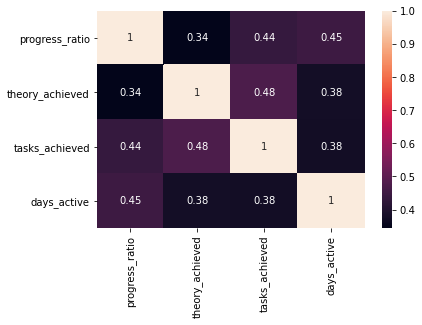

In [108]:
sns.heatmap(df.corr(method="kendall"), annot=True)

<AxesSubplot:>

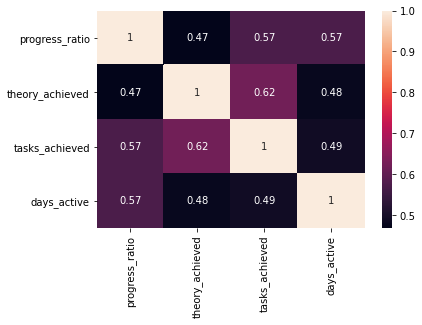

In [109]:
sns.heatmap(df.corr(method="spearman"), annot=True)